# Use this package

## Set up

Clone this repository
```$ git clong https://github.com/pauljhp/StockSentimentAnalysis/```

Make sure you are using conda. The following script uses codna to set up the environment

Then run the setup script
```$ sudo bash setup.sh ```

In [15]:
import news_sentiment
import datetime as dt
summary = news_sentiment.get_daily_sentiment_series("FB", 
    start_date=dt.date(2022, 1, 1), lim=1000)

In [19]:
summary.head(5)

title_sentiment                  content_sentiment           \
                  positive negative neutral          positive negative   
2022-01-03             NaN      NaN     NaN               NaN      NaN   
2022-01-04             NaN      NaN     NaN               NaN      NaN   
2022-01-05             NaN      NaN     NaN               NaN      NaN   
2022-01-06             NaN      NaN     NaN               NaN      NaN   
2022-01-07             NaN      NaN     NaN               NaN      NaN   

                   news_count    price                                       \
           neutral      count     open      high       low   close adjClose   
2022-01-03     NaN        NaN  338.295  341.0816  337.1900  338.54   338.54   
2022-01-04     NaN        NaN  339.950  343.0900  331.8700  336.53   336.53   
2022-01-05     NaN        NaN  333.020  335.7600  323.8600  324.17   324.17   
2022-01-06     NaN        NaN  322.820  339.1700  322.7200  332.46   332.46   
2022-01-07     NaN        NaN  332.740  336.9700  328.8801  331.79   331.79   

                                                                         \
                volume unadjustedVolume change changePercent       vwap   
2022-01-03  14563294.0       14563294.0  0.245         0.072  338.93720   
2022-01-04  15989000.0       15989000.0 -3.420        -1.006  337.16333   
2022-01-05  20267868.0       20267868.0 -8.850        -2.657  327.93000   
2022-01-06  27948072.0       27948072.0  9.640         2.986  331.45000   
2022-01-07  14722959.0       14722959.0 -0.950        -0.286  332.54670   

                           
           changeOverTime  
2022-01-03        0.00072  
2022-01-04       -0.01006  
2022-01-05       -0.02657  
2022-01-06        0.02986  
2022-01-07       -0.00286

In [20]:
summary.corr()

title_sentiment                      \
                                          positive  negative   neutral   
title_sentiment   positive                1.000000 -0.395831 -0.231372   
                  negative               -0.395831  1.000000 -0.801821   
                  neutral                -0.231372 -0.801821  1.000000   
content_sentiment positive                0.252963 -0.387838  0.246267   
                  negative               -0.151504  0.489548 -0.420038   
                  neutral                -0.014187 -0.269064  0.294276   
news_count        count                   0.002358  0.170508 -0.182170   
price             open                   -0.025982  0.177059 -0.184858   
                  high                   -0.032878  0.147998 -0.147672   
                  low                    -0.022846  0.123758 -0.126335   
                  close                  -0.028806  0.095484 -0.090615   
                  adjClose               -0.028806  0.095484 -0.090615   
                  volume                 -0.026824  0.283893 -0.305497   
                  unadjustedVolume       -0.026824  0.283893 -0.305497   
                  change                 -0.007302 -0.220742  0.254813   
                  changePercent          -0.021429 -0.215178  0.257168   
                  vwap                   -0.028402  0.123352 -0.122466   
                  changeOverTime         -0.021429 -0.215178  0.257168   

                                   content_sentiment                      \
                                            positive  negative   neutral   
title_sentiment   positive                  0.252963 -0.151504 -0.014187   
                  negative                 -0.387838  0.489548 -0.269064   
                  neutral                   0.246267 -0.420038  0.294276   
content_sentiment positive                  1.000000 -0.491898 -0.177063   
                  negative                 -0.491898  1.000000 -0.769799   
                  neutral                  -0.177063 -0.769799  1.000000   
news_count        count                    -0.050648  0.121706 -0.100447   
price             open                      0.100254  0.145639 -0.238100   
                  high                      0.121492  0.098133 -0.194930   
                  low                       0.138751  0.093587 -0.200537   
                  close                     0.153134  0.061503 -0.171408   
                  adjClose                  0.153134  0.061503 -0.171408   
                  volume                   -0.087700  0.190683 -0.171708   
                  unadjustedVolume         -0.087700  0.190683 -0.171708   
                  change                    0.140817 -0.227278  0.181455   
                  changePercent             0.130594 -0.228987  0.190034   
                  vwap                      0.139065  0.085068 -0.190562   
                  changeOverTime            0.130594 -0.228987  0.190034   

                                   news_count     price                      \
                                        count      open      high       low   
title_sentiment   positive           0.002358 -0.025982 -0.032878 -0.022846   
                  negative           0.170508  0.177059  0.147998  0.123758   
                  neutral           -0.182170 -0.184858 -0.147672 -0.126335   
content_sentiment positive          -0.050648  0.100254  0.121492  0.138751   
                  negative           0.121706  0.145639  0.098133  0.093587   
                  neutral           -0.100447 -0.238100 -0.194930 -0.200537   
news_count        count              1.000000  0.086220  0.097473  0.049215   
price             open               0.086220  1.000000  0.997452  0.997065   
                  high               0.097473  0.997452  1.000000  0.997531   
                  low                0.049215  0.997065  0.997531  1.000000   
                  close              0.077907  0.992222  0.996801  0.996925   
      

## Visualize sentiment

[Text(0, 0.5, 'avg softmax'), Text(0.5, 1.0, 'FB sentiment')]

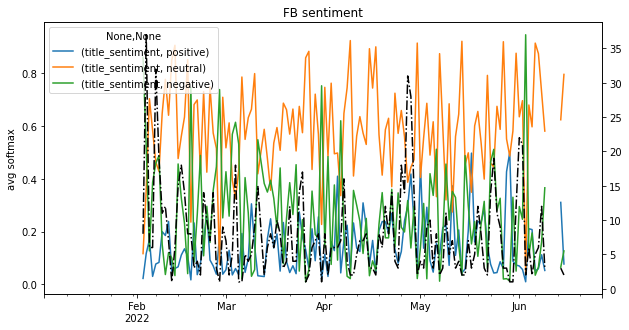

In [22]:
import matplotlib.pyplot as plt
import itertools
f, ax = plt.subplots(1, figsize=(10,5))
summary.loc[:, itertools.product(["title_sentiment"], 
    ["positive", "neutral", "negative"])].plot(ax=ax)
summary.loc[:, ("news_count", "count")].plot(ax=ax, secondary_y=True, 
    color='black', linestyle="-.",
    label="news count")
ax.set(ylabel="avg softmax",
    title="FB sentiment")

## Check correlation

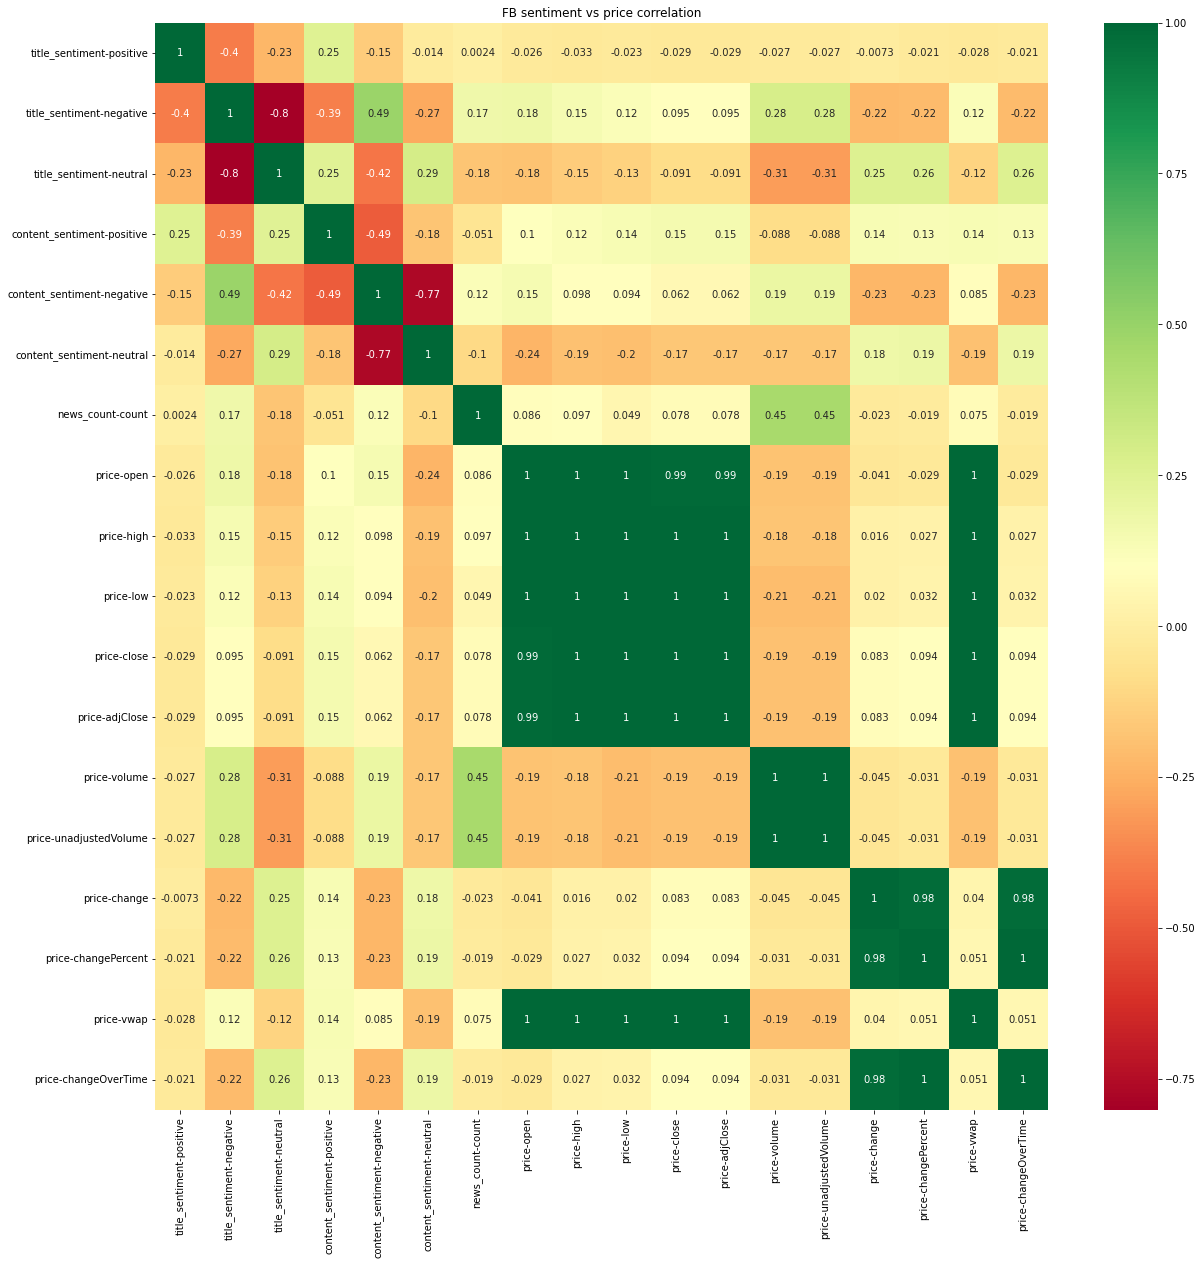

In [23]:
import seaborn as sns
f, ax = plt.subplots(1, figsize=(20, 20))
sns.heatmap(summary.corr(), annot=True, ax=ax, cmap="RdYlGn")
ax.set(title="FB sentiment vs price correlation")
ax.set(xlabel=None, ylabel=None)
plt.show()